# Overview 

<span style="color:red; font-size:18px; font-weight:bold;">In this notebook, we will try to create a workflow between Langchain and Mixtral LLM.</br>
We want to accomplish the following:</span>
1. Establish a pipeline to read in a csv and pass it to our LLM. 
2. Establish a Pandas Agent in our LLM.
3. Connect the CSV pipeline to this agent and enable a end-end EDA pipeline.

# Setting up the Environment 

In [1]:
####################################################################################################
import os
import re
import subprocess
import sys

from langchain import hub
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_experimental.utilities import PythonREPL
from langchain.agents import Tool
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

from langchain.agents import AgentExecutor

from langchain.agents import create_structured_chat_agent
from langchain.memory import ConversationBufferWindowMemory

from langchain.output_parsers import PandasDataFrameOutputParser
from langchain.prompts import PromptTemplate

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_community.chat_models import ChatAnyscale
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

plt.style.use('ggplot')
####################################################################################################

In [2]:
# insert your API key here
os.environ["ANYSCALE_API_KEY"] = "esecret_8btufnh3615vnbpd924s1t3q7p"
memory_key = "history"

# Using out of the box agents
<span style="font-size:16px;color:red;"> Over here we simply try to run the Pandas Dataframe agent provided by langchain out of the box. It uses a CSV parser and has just one tool, the __PythonAstREPLTool__ which helps it execute python commands in a shell and display output. </span>

In [28]:
df = pd.read_csv('../data/train.csv')
df.to_csv('./df.csv', index=False)

# DECLARE YOUR LLM HERE 

In [4]:
llm = ChatAnyscale(model_name='mistralai/Mixtral-8x7B-Instruct-v0.1', temperature=0.1)
agent = create_pandas_dataframe_agent(llm, df, verbose=True)

# Building my own DF chain
<span style="font-size:16px;color:red"> The above agent does not work well or mistral out of the box. The mistral LLM is unable to use the tools properly. It perhaps needs much more hand-held prompts.</span>

### Post Implementation Observation:
<span style="font-size:16px;color:red"> We were able to observe the following:</br>
    1. The agent now works very well almost always returning the desired output.</br>
    2. The agent is unable to output plots. </span>

# Building an Agent 

In [5]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""You are Data Analysis assistant. Your job is to use your tools to answer a user query in the best\
            manner possible. Your job is to respond to user queries by generating a python code file.\
            Make sure to include all necessary imports.\
            In case you make plots, make sure to label the axes and add a good title too. \
            You must save any plots in the 'graphs' folder as png only.\
            Provide no explanation for your code.\
            Read the data from 'df.csv'.\
            ** Enclose all your code between triple backticks ``` **\
            RECTIFY ANY ERRORS FROM THE PREVIOUS RUNS.
            """,
        ),
        ("user", "Dataframe named df: {df}\nQuery: {input}\nTools:{tools}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [6]:
python_repl = PythonREPL()

repl_tool = Tool(
    name="python_repl",
    description="""A Python shell. Shell can dislay charts too. Use this to execute python commands.\
    You have access to all libraries in python including but not limited to sklearn, pandas, numpy,\
    matplotlib.pyplot, seaborn etc. Input should be a valid python command. If the user has not explicitly\
    asked you to plot the results, always print the final output using print(...)""",
    func=python_repl.run,
)

tools = [repl_tool]

In [7]:
agent = (
    {
        "input": lambda x: x["input"],
        "tools": lambda x:x['tools'],
        "df": lambda x:x['df'],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        )
    }
    | prompt
    | llm
    | OpenAIToolsAgentOutputParser()
)

In [8]:
agent_executor = AgentExecutor(agent=agent, tools=tools, df = 'df.csv', verbose=True)

In [9]:
def infer(path:str = '', user_input:str = ''):
    
    error_flag = True
    
    while error_flag:
        result = list(agent_executor.stream({"input": user_input, 
                                     "df":pd.read_csv('df.csv'),
                                     "tools":tools}))

        # need to extract the code
        pattern = r"```python\n(.*?)\n```"
        matches = re.findall(pattern, result[0]['output'], re.DOTALL)
        final_line = "df.to_csv('./df.csv', index=False)"
        code = "\n".join(matches)

        # execute the code
        try:
            exec(code)
            error_flag = False
        except:
            print("Error occurred!")
            error_flag = True
        
    return result[0]['output']

# Testing 
<span style="font-size:16px;color:red;"> Testing for the EDA Agent has been divided into 2 distinct tasks:</span>
## <span style="font-size:16px">**Data Smoothing**:</span>
><span style="font-size:16px">i. Finding out the Null values.</span></br>
><span style="font-size:16px">ii. Filling the Null values.</span>

## <span style="font-size:16px">**Plotting**:</span>
><span style="font-size:16px">i. Distribution of ages</span></br>
><span style="font-size:16px">ii. Distribution of gender against survival.</span></br>
><span style="font-size:16px">iii. Heatmap of all variables with survival.</span> </br>
><span style="font-size:16px">iv. Reg plot age against fare (since these are the only continuous features in our dataset)</span>


## Smoothing



> Entering new AgentExecutor chain...
 ```python
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('df.csv')

# Calculate the number of null values in each column
null_counts = df.isnull().sum()

# Create a bar plot of the null counts
null_counts.plot(kind='bar')

# Set the title and label the axes
plt.title('Count of Null Values in Every Column')
plt.xlabel('Column Name')
plt.ylabel('Number of Null Values')

# Save the plot as a png in the 'graphs' folder
plt.savefig('graphs/null_counts.png')

# Display the plot
plt.show()
```

> Finished chain.


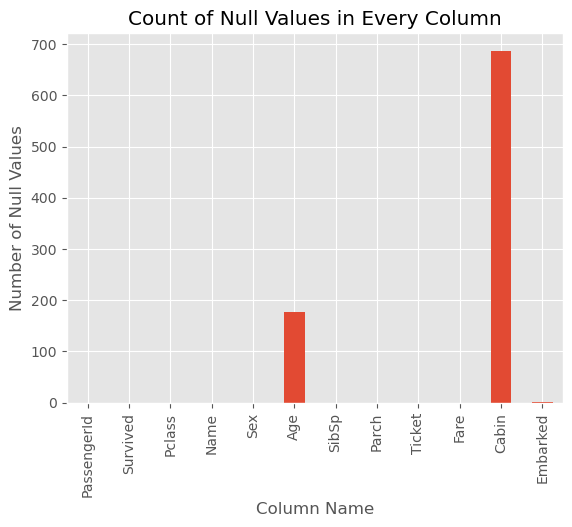

In [10]:
output = infer("Make a plot of count of null values in every column.")

In [11]:
output = infer("How many null values are there in total? Do not give me a plot")



> Entering new AgentExecutor chain...
 ```python
import pandas as pd

df = pd.read_csv('df.csv')

total_null_values = df.isnull().sum().sum()

print(f"Total number of null values: {total_null_values}")
```

> Finished chain.
Total number of null values: 866


In [12]:
output = infer("Fill in most occuring values in the column in place of null values in the dataframe")



> Entering new AgentExecutor chain...
 ```python
import pandas as pd
import numpy as np

# Read the data
df = pd.read_csv('df.csv')

# Fill NA/NaN values with the most frequent value in each column
df['Sex'] = df['Sex'].fillna(df['Sex'].mode()[0])
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Age'] = df['Age'].fillna(df['Age'].mode()[0])
df['Cabin'] = df['Cabin'].fillna(df['Cabin'].mode()[0])
df['Ticket'] = df['Ticket'].fillna(df['Ticket'].mode()[0])

# Save the modified dataframe
df.to_csv('df_filled.csv', index=False)
```

> Finished chain.


## Plotting 



> Entering new AgentExecutor chain...
 ```python
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from 'df.csv'
df = pd.read_csv('df.csv')

# Plot the distribution of ages
plt.figure(figsize=(10, 6))
plt.hist(df['Age'].dropna(), bins=30)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Ages')
plt.grid(True)
plt.savefig('graphs/age_distribution.png')
```

> Finished chain.


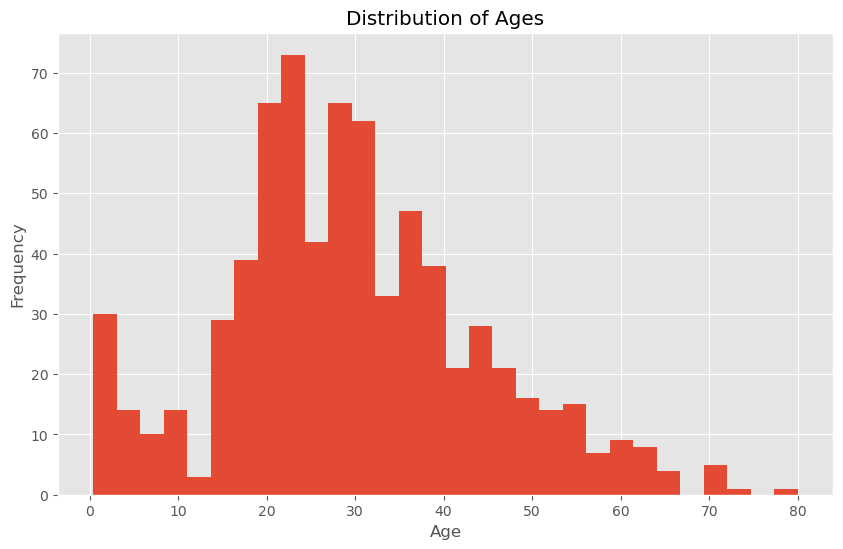

In [13]:
output = infer("Please plot the distribution of ages.")



> Entering new AgentExecutor chain...
 ```python
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from 'df.csv'
df = pd.read_csv('df.csv')

# Plot the distribution of gender against survival
plt.figure(figsize=(10, 6))
plt.hist(df['Survived'], bins=[0, 1], alpha=0.5, label='Died')
plt.hist(df[df['Survived'] == 1]['Sex'].map({'male': 0, 'female': 1}).values, bins=[0, 1], alpha=0.5, label='Survived')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Distribution of Gender against Survival')
plt.legend()
plt.savefig('graphs/distribution_of_gender_against_survival.png')
plt.show()
```

> Finished chain.


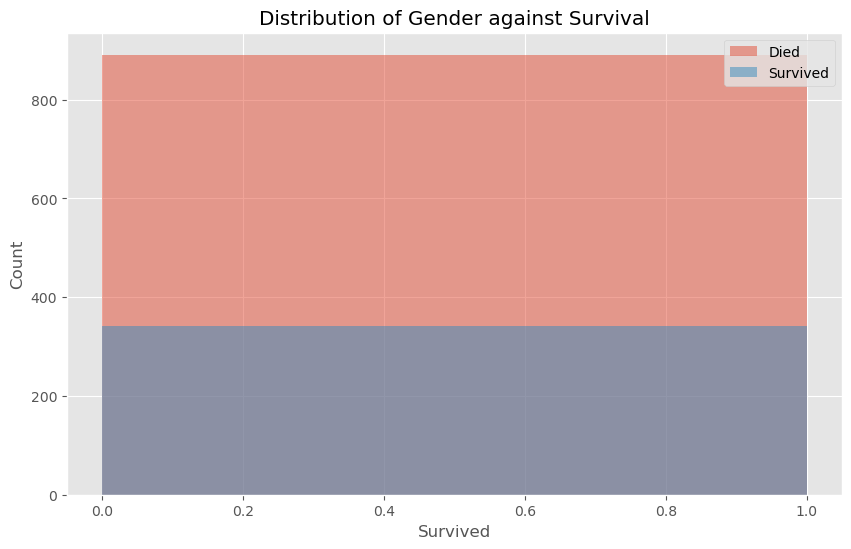

In [14]:
output = infer("Please plot the distribution of gender against survival. Add suitable labels and title.")



> Entering new AgentExecutor chain...
 ```python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

# Read the data
df = pd.read_csv('df.csv')

# Perform ordinal encoding on Embarked column
encoder = OrdinalEncoder()
df['Embarked'] = encoder.fit_transform(df[['Embarked']])

# Prepare the data for heatmap
pivot_data = pd.pivot_table(df, values='Survived', index=['Pclass', 'Embarked'], columns=['Age', 'Fare'])

# Generate the heatmap
sns.heatmap(pivot_data, cmap='YlGnBu')
plt.title('Heatmap of Survived vs Pclass, Embarked, Age, and Fare')
plt.savefig('graphs/heatmap.png')
plt.show()
```

> Finished chain.


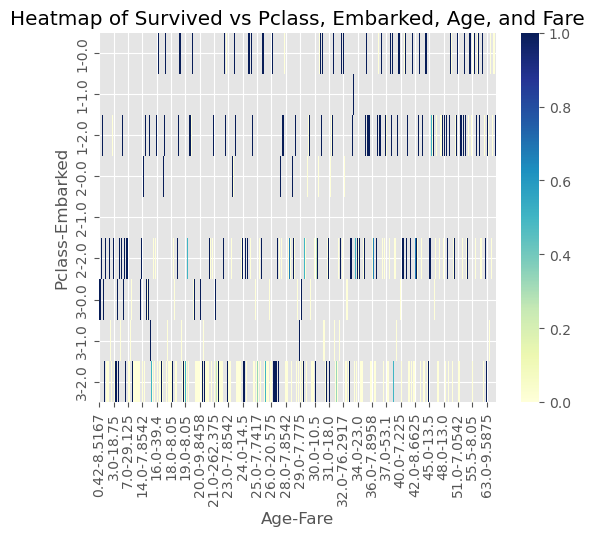

In [15]:
output = infer("Follow these steps:1. Perform ordinal encoding on Embarked column and 2. Now plot a heatmap of this transformed embarked along with PClass, Age and Fare against Survived. Do both 1 and 2")



> Entering new AgentExecutor chain...
 ```python
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('df.csv')

# Create a regplot of age against fare
sns.regplot(x='Age', y='Fare', data=df)

# Set the plot title and labels
plt.title('Regression Plot of Age vs Fare')
plt.xlabel('Age')
plt.ylabel('Fare')

# Display the plot
plt.show()
```
```

> Finished chain.


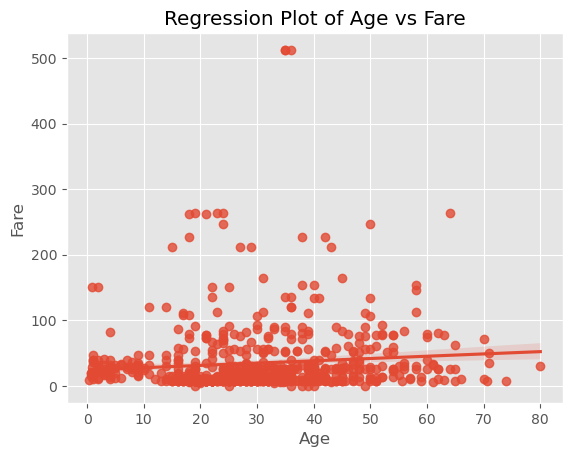

In [16]:
output = infer("Please plot a reg-plot of age against fair. Add a suitable title and labels.")

### The changed dataframe is being passed between inferences

In [17]:
output = infer("Print the unique values from the Embarked column")



> Entering new AgentExecutor chain...
 ```python
import pandas as pd

# Read the data from 'df.csv'
df = pd.read_csv('df.csv')

# Print the unique values from the Embarked column
print(df['Embarked'].unique())
```

> Finished chain.
['S' 'C' 'Q' nan]


# Gradio Demo

In [32]:
type(df)

pandas.core.frame.DataFrame

In [56]:
def myFunc(path, query):
    return None

In [ ]:
demo = gr.Interface (
    myFunc,
    [
        gr.Text(label="JSON Object",info="Please enter the JSON Object."),
        gr.Radio(["Question","Answer_Choice","Sub_Question","Sub_Answer_Choice","Partial_Clause"],label="Select Component Type",info="Which component do you want to edit?"),
        gr.Text(label="Question No.",info="Plese enter the question number i.e., 1 for Q1, 2 for Q2 ..."),
        gr.Text(label="Answer Choice", info="Please enter the Answer Choice in this format: a for 1st, b for 2nd ..."),
        gr.Text(label="Sub Answer Choice", info="Please enter the sub-answer choice in this format: a for 1st, b for 2nd ..."),
        gr.Text(label="Update Instructions",info="Please enter the update instructions."),
        gr.Slider(label="Model Temperature", info="Slide right to make your model more creative!")
    ],
    gr.Text(label="Updated JSON Object", info="This the JSON Object with the changed component.")
)
demo.launch(share=True)

In [53]:
from pathlib import Path
import gradio as gr

def upload_file(filepath):
    name = Path(filepath).name
    df_func = pd.read_csv(filepath)
    
    return None

with gr.Blocks() as demo:
    gr.Markdown("First upload a file and and then you'll be able download it (but only once!)")
    with gr.Row():
        u = gr.UploadButton("Upload a file", file_count="single")
    with gr.Row():
        d = gr.Text("Who would you like to say hello to", )
        
    u.upload(upload_file, u, [])
    
    
    
demo.launch()

Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.
